In [ ]:
!pip install transformers==2.6.0

In [ ]:
!pip install h5py==2.8.0rc1

In [ ]:
!pip install torch

In [ ]:
!pip install pyopenssl


In [ ]:
!pip install sklearn

In [1]:
import tensorflow as tf
# import tensorflow as tf
print(tf.__version__)
import torch
torch.cuda.is_available()

2.4.0


True

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
torch.__version__

Using TensorFlow backend.


'1.7.1+cu110'

In [3]:
MAX_LEN = 64
bs = 64

In [4]:
input_ids=pickle.load(open("./data/input_ids",'rb'))
tags=pickle.load(open("./data/tags",'rb'))
attention_masks=pickle.load(open("./data/attention_masks",'rb'))
# attention_masks = [[int(v) for v in u] for u in attention_masks]
tr_inputs = input_ids
tr_tags = tags
tr_masks = attention_masks


In [5]:
input_ids=pickle.load(open("./data/test_input_ids",'rb'))
tags=pickle.load(open("./data/test_tags",'rb'))
attention_masks=pickle.load(open("./data/test_attention_masks",'rb'))

# attention_masks = [[int(v) for v in u] for u in attention_masks]
val_inputs = input_ids
val_tags = tags
val_masks = attention_masks


In [6]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [7]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [8]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'4.4.0'

In [9]:
tag_values = [0, 1]
tag_values.append(2)
tag2idx = {t: i for i, t in enumerate(tag_values)}

model = BertForTokenClassification.from_pretrained(
    'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

In [10]:
model.cuda();

In [11]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)

In [12]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [13]:
from sklearn.metrics import f1_score, accuracy_score

In [14]:
torch.cuda.is_available()

True

In [15]:
## Store the average loss after each epoch so we can plot them.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
#         b_input_ids = b_input_ids.type(torch.LongTensor)
#         b_input_mask= b_input_mask.type(torch.LongTensor)
#         b_labels = b_labels.type(torch.LongTensor)
        
#         b_input_ids = b_input_ids.to(device)
#         b_input_mask = b_input_mask.to(device)
#         b_labels = b_labels.to(device)
        b_input_ids = torch.tensor(b_input_ids).to(torch.int64)
        b_input_mask = torch.tensor(b_input_mask).to(torch.int64)
        b_labels = torch.tensor(b_labels).to(torch.int64)
        
        
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        b_input_ids = torch.tensor(b_input_ids).to(torch.int64)
        b_input_mask = torch.tensor(b_input_mask).to(torch.int64)
        b_labels = torch.tensor(b_labels).to(torch.int64)

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i]  for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != 2]
    
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != 2]
        
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|                                                                                                                                                                           | 0/3 [00:00<?, ?it/s]e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Average train loss: 0.18441066588854316


e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch:  33%|██████████████████████████████████████████████████████▎                                                                                                            | 1/3 [00:53<01:47, 53.75s/it]

Validation loss: 0.13605658011510968
Validation Accuracy: 0.951179693615118
Validation F1-Score: 0.786878844088646



e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Average train loss: 0.1362871830884497


e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 2/3 [01:47<00:53, 53.72s/it]

Validation loss: 0.1425204509869218
Validation Accuracy: 0.9516716985351672
Validation F1-Score: 0.7864835490564173



e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Average train loss: 0.11769815894371982


e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\ljx\step3-v4\venv\lib\site-packages\ipykernel_launcher.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:41<00:00, 53.76s/it]

Validation loss: 0.1553073914255947
Validation Accuracy: 0.9506429609750643
Validation F1-Score: 0.7870718765074771



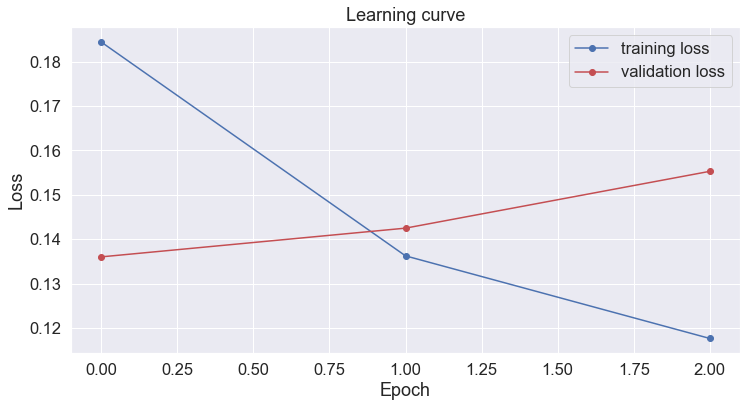

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [17]:
torch.save(model, './model.pth')

In [18]:
test_sentences =[
    """
    Weaned off vent to CPAP and was extubated in the afternoon on 9-2 by the pulmonary team .
    """,
    """
    She was intubated and was resuscitated after 10-22 minutes of PEA arrest .
    """,
    """
    He was given succinyl choline and etomidate for intubation .
    """,
    """
    Had post-op anemia and was transfused with appropriate effect .
    """,
    """
    Per patient , he took Pepto-Bismol 3 times earlier in the weeks for 3 days .
    """,
    """
    Pt is a 89 yo male with SSS s/p pacer , admitted to Neurosurgery with SDH with acute respiratory distress/ wheezing on the floor .
    """,
    """
    Known lastname 28272 is a 63 year-old man with PAF , PVD , HLD , HTN and OSA with complaint of several months of exertional chest pain and dyspnea .
    """
]



In [19]:
import numpy as np
 
def softmax(x, axis=1):
    row_max = x.max(axis=axis)
 
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s


In [23]:
tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')

for test_sentence in test_sentences:

    tokenized_sentence = tokenizer.encode(test_sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()

    with torch.no_grad():
        output = model(input_ids)
    logits = output[0].to('cpu').numpy()[0]
    prob = softmax(logits)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    new_prob = []
    new_prob_ = []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
            new_prob.append(prob[label_idx][1])
            new_prob_.append(prob[label_idx][0])
            
    i = 0
    for token, label in zip(new_tokens, new_labels):
        print("{:.4f}\t{}\t{}".format(new_prob[i], label, token))
        i += 1
    print("")

0.0453	0	[CLS]
0.0453	0	weaned
0.0453	0	off
0.0453	0	vent
0.0453	0	to
0.0328	1	cpap
0.0453	0	and
0.0453	0	was
0.0453	0	extubated
0.0453	0	in
0.0453	0	the
0.0453	0	afternoon
0.0453	0	on
0.0453	0	9
0.0453	0	-
0.0453	0	2
0.0453	0	by
0.0453	0	the
0.0328	1	pulmonary
0.0453	0	team
0.0453	0	.
0.0453	0	[SEP]

0.0584	0	[CLS]
0.0584	0	she
0.0584	0	was
0.0584	0	intubated
0.0584	0	and
0.0584	0	was
0.0584	0	resuscitated
0.0584	0	after
0.0584	0	10
0.0584	0	-
0.0584	0	22
0.0584	0	minutes
0.0584	0	of
0.0840	1	pea
0.0584	0	arrest
0.0584	0	.
0.0584	0	[SEP]

0.0517	0	[CLS]
0.0517	0	he
0.0517	0	was
0.0517	0	given
0.0517	0	succinyl
0.0517	0	choline
0.0517	0	and
0.0517	0	etomidate
0.0517	0	for
0.0517	0	intubation
0.0517	0	.
0.0517	0	[SEP]

0.1409	0	[CLS]
0.1409	0	had
0.1409	0	post
0.1409	0	-
0.0599	1	op
0.0599	1	anemia
0.1409	0	and
0.1409	0	was
0.1409	0	transfused
0.1409	0	with
0.1409	0	appropriate
0.1409	0	effect
0.1409	0	.
0.1409	0	[SEP]

0.0519	0	[CLS]
0.0519	0	per
0.0519	0	patient
0.0519	0	,
0.0519	0	he